<a href="https://colab.research.google.com/github/filipegl/Multi-label-Text-Classification/blob/master/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data
Download the **Comma Separated Values File** [here](https://catalog.data.gov/dataset/consumer-complaint-database) and unzip.\
We will use this data to predict a product from a consumer complaint

In [0]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Change to your location
df = pd.read_csv('drive/My Drive/Colab Notebooks/complaints.csv')
print(df.shape)
df.head(3)

(1608094, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206,NaN,Consent not provided,Web,2019-09-20,Closed with non-monetary relief,Yes,NaN,3379500
2,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821


## Cleaning data

In [4]:
# Restrict the table with only two columns: 'Product' and 'Consumer complaint narrative'
df = df[['Product', 'Consumer complaint narrative']]
# Remove NaN values
df = df[pd.notnull(df['Consumer complaint narrative'])]
# Creates a new column called 'category_id' whose takes a unique id per product. The factorize() is responsable for transform these products into ids
df['category_id'] = df['Product'].factorize()[0]
df

,Product,Consumer complaint narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,1
3,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
11,"Money transfer, virtual currency, or money ser...","I was sold access to an event digitally, of wh...",2
12,Debt collection,While checking my credit report I noticed thre...,0
...,...,...,...
1608089,Consumer Loan,I was on automatic payment for my car loan. In...,10
1608090,Debt collection,I recieved a collections call from an unknown ...,0
1608091,Mortgage,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who...",3
1608092,Mortgage,I can not get from chase who services my mortg...,3


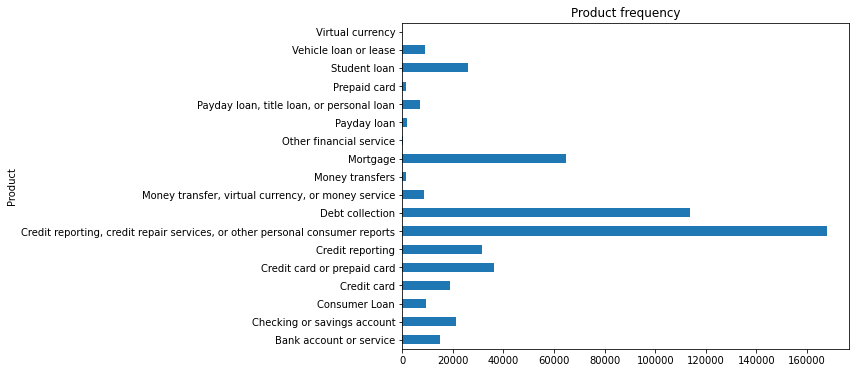

In [7]:
# Remove all duplicate products and sort by id.
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# plot graphic
df.groupby('Product')['Consumer complaint narrative'].count().plot(kind='barh', title='Product frequency', figsize=(8,6))
plt.show()

## TF-IDF

In [9]:
# Convert the 'consumer complaint narrative' to a matrix of TF-IDF features.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['Consumer complaint narrative'])
features.shape

(535060, 919283)

## Most correlated unigrams and bigrams of each product
We will use statistics methods like [chi-squared](https://en.wikipedia.org/wiki/Chi-squared_test)

In [37]:
# category_to_id is a dict {product: id}
category_to_id = dict(category_id_df.values)
# id_to_category is a dict {id: product}
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

labels = df['category_id']

# a for loop on all products and their respective ids, in order
for Product, category_id in sorted(category_to_id.items()):
  # chi2 computes chi-squared (χ²) statistics.
  # This score will be used to select the n_features with the highest values for
  # the test chi-squared statistic.
  features_chi2 = chi2(features, labels == category_id)
  # np.argsort returns the indices of a sorted features
  indices = np.argsort(features_chi2[0])
  # transform the tfidf numbers into words
  feature_names = np.array(tfidf.get_feature_names())[indices]

  # get unigrams and bigrams from feature_names
  unigrams = [e for e in feature_names if len(e.split(' ')) == 1]
  bigrams = [e for e in feature_names if len(e.split(' ')) == 2]

  print("# '{}':".format(Product))
  print("  - Most correlated unigrams:\n-------> {}".format('\n-------> '.join(unigrams[-2:])))
  print('~~~~~~~~~~~~~~')
  print("  - Most correlated bigrams:\n-------> {}".format('\n-------> '.join(bigrams[-2:])))
  print('=============================')

# 'Bank account or service':
  - Most correlated unigrams:
-------> bank
-------> overdraft
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> overdraft fees
-------> checking account
# 'Checking or savings account':
  - Most correlated unigrams:
-------> branch
-------> deposit
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> savings account
-------> checking account
# 'Consumer Loan':
  - Most correlated unigrams:
-------> vehicle
-------> car
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> drive time
-------> auto loan
# 'Credit card':
  - Most correlated unigrams:
-------> macy
-------> card
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> american express
-------> credit card
# 'Credit card or prepaid card':
  - Most correlated unigrams:
-------> express
-------> card
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> american express
-------> credit card
# 'Credit reporting':
  - Most correlated unigrams:
-------> experian
-------> equifax
~~~~~~~~~~~~~~
  - Most

## Training the **Linear Support Vector Classification** model

In [0]:
# split features and labels
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 41)

In [39]:
# fit the model with feature x and label y
model = LinearSVC()
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [40]:
# show the classification report for each produtc
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                             Debt collection       0.83      0.87      0.85     28470
Credit reporting, credit repair services, or other personal consumer reports       0.84      0.90      0.87     42013
                          Money transfer, virtual currency, or money service       0.75      0.71      0.73      2204
                                                                    Mortgage       0.91      0.95      0.93     16211
                                                                Student loan       0.88      0.88      0.88      6502
                                                 Credit card or prepaid card       0.67      0.73      0.70      9124
                                   Payday loan, title loan, or personal loan       0.62      0.41      0.50      1856
                                                 Checki

## Most correlated unigrams and bigrams of each product
But now we will use the model to get the informations



In [41]:
model.fit(features, labels)

for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]

  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:2]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:2]

  print("# '{}':".format(Product))
  print("  - Most correlated unigrams:\n-------> {}".format('\n-------> '.join(unigrams[-2:])))
  print('~~~~~~~~~~~~~~')
  print("  - Most correlated bigrams:\n-------> {}".format('\n-------> '.join(bigrams[-2:])))
  print('=============================')

# 'Bank account or service':
  - Most correlated unigrams:
-------> scottrade
-------> bank
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> xx 2017
-------> xx 2016
# 'Checking or savings account':
  - Most correlated unigrams:
-------> bank
-------> funds
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> debit card
-------> debt card
# 'Consumer Loan':
  - Most correlated unigrams:
-------> drivetime
-------> ally
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> drive time
-------> xxxx points
# 'Credit card':
  - Most correlated unigrams:
-------> macy
-------> card
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> xx 2016
-------> xx 2017
# 'Credit card or prepaid card':
  - Most correlated unigrams:
-------> card
-------> capital
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> 2016 sure
-------> verification capital
# 'Credit reporting':
  - Most correlated unigrams:
-------> equifax
-------> experian
~~~~~~~~~~~~~~
  - Most correlated bigrams:
-------> xxxx poi

## Manually test
To make manually test, the y_test can't be numbers. Y_test will be a string containing a simple complaint narrative.

In [0]:
# Note that the X and Y will be the raw text.
X_train1, _ , y_train1, _ = train_test_split(df['Consumer complaint narrative'], df['Product'], random_state = 24)
# Here we will convert the text into tokens
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train1)
# Transform the tokens into TF-IDF representation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Fit the classifier
clf = LinearSVC().fit(X_train_tfidf, y_train1)

In [43]:
# You can change the text to predict different produtcs
complaint_narrative = "I really want this car!"
print(clf.predict(count_vect.transform([complaint_narrative])))

['Vehicle loan or lease']
